In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os
from omegaconf import OmegaConf
from models.flow_module import FlowModule
import torch
from data.pdb_dataloader import PdbDataModule
import glob
import GPUtil
from data import utils as du
import numpy as np
import tree
from data import so3_utils
from data import all_atom
from analysis import utils as au
from openfold.utils.superimposition import superimpose
import matplotlib.pyplot as plt
from tmtools import tm_align
import pandas as pd
import shutil
from openfold.utils.superimposition import superimpose
import plotnine as gg
from tqdm import tqdm
import mdtraj as md


In [35]:
results_dir = '/data/rsg/chemistry/jyim/projects/flow-matching/inference_outputs/refactor_with_align/2023-10-15_18-12-18/last/run_2023-10-18_00-30-21/'
# results_dir = '/data/rsg/chemistry/jyim/projects/flow-matching/inference_outputs/baseline_2023-10-15_10-55-55_last/ts_100/frame_mpnn/reverse_time/ode/NS_1.0'
# results_dir = '/data/rsg/chemistry/jyim/projects/flow-matching/inference_outputs/refactor_with_align/2023-10-15_18-12-18/last/run_2023-10-17_08-11-27'
# results_dir = '/data/rsg/chemistry/jyim/projects/flow-matching/inference_outputs/baseline_2023-10-06_01-14-03_last/ts_100/frame_mpnn/reverse_time_100/ode'
all_csvs = glob.glob(os.path.join(results_dir, '*/top_samples.csv'))
all_results_csv = []
for csv in all_csvs:
    csv_df = pd.read_csv(csv)
    all_results_csv.append(csv_df)
results_df = pd.concat(all_results_csv)
designable_df = results_df[results_df.rmsd < 2.0]

In [44]:
strand_per_length = designable_df.groupby('length').strand_percent.mean().reset_index()
strand_per_length['class'] = 'model'

In [40]:
csv_path = '/data/rsg/chemistry/jyim/projects/flow-matching/preprocessed/metadata.csv'
data_df = pd.read_csv(csv_path)

In [50]:
data_strand_per_length = data_df.groupby('seq_len').strand_percent.mean().reset_index()
data_strand_per_length['length'] = data_strand_per_length['seq_len']
data_strand_per_length['class'] = 'data'
data_strand_per_length = data_strand_per_length[(data_strand_per_length.length >= 60) & (data_strand_per_length.length <= 128)]

In [57]:
length_df = data_df[(data_df['modeled_seq_len'] >= 60) & (data_df['modeled_seq_len'] <= 128)]

In [107]:
all_rows = list(length_df.iterrows())

In [108]:
all_strand = []
all_helix = []
all_coil = []
all_length = []
for i, row in tqdm(all_rows):
    raw_path = row.raw_path

    # MDtraj
    traj = md.load(raw_path)

    # SS calculation
    pdb_ss = md.compute_dssp(traj, simplified=True)
    pdb_ss = pdb_ss[0]
    # if pdb_ss.shape[0] != 1:
    #     print(f'Skipping {raw_path}: {pdb_ss.shape}')
    #     continue
    strand_percent = np.mean(pdb_ss == 'E')
    helix_percent = np.mean(pdb_ss == 'H')
    coil_percent = np.mean(pdb_ss == 'C')
    all_strand.append(strand_percent)
    all_helix.append(helix_percent)
    all_coil.append(coil_percent)
    all_length.append(row.modeled_seq_len)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3673/3673 [11:11<00:00,  5.47it/s]


In [115]:
data_strand_per_length = pd.DataFrame({
    'strand_percent': all_strand,
    'length': all_length
})
data_strand_per_length = data_strand_per_length.groupby('length').strand_percent.mean().reset_index()
data_strand_per_length['class'] = 'data'

In [116]:
all_strand_per_length = pd.concat([data_strand_per_length, strand_per_length])

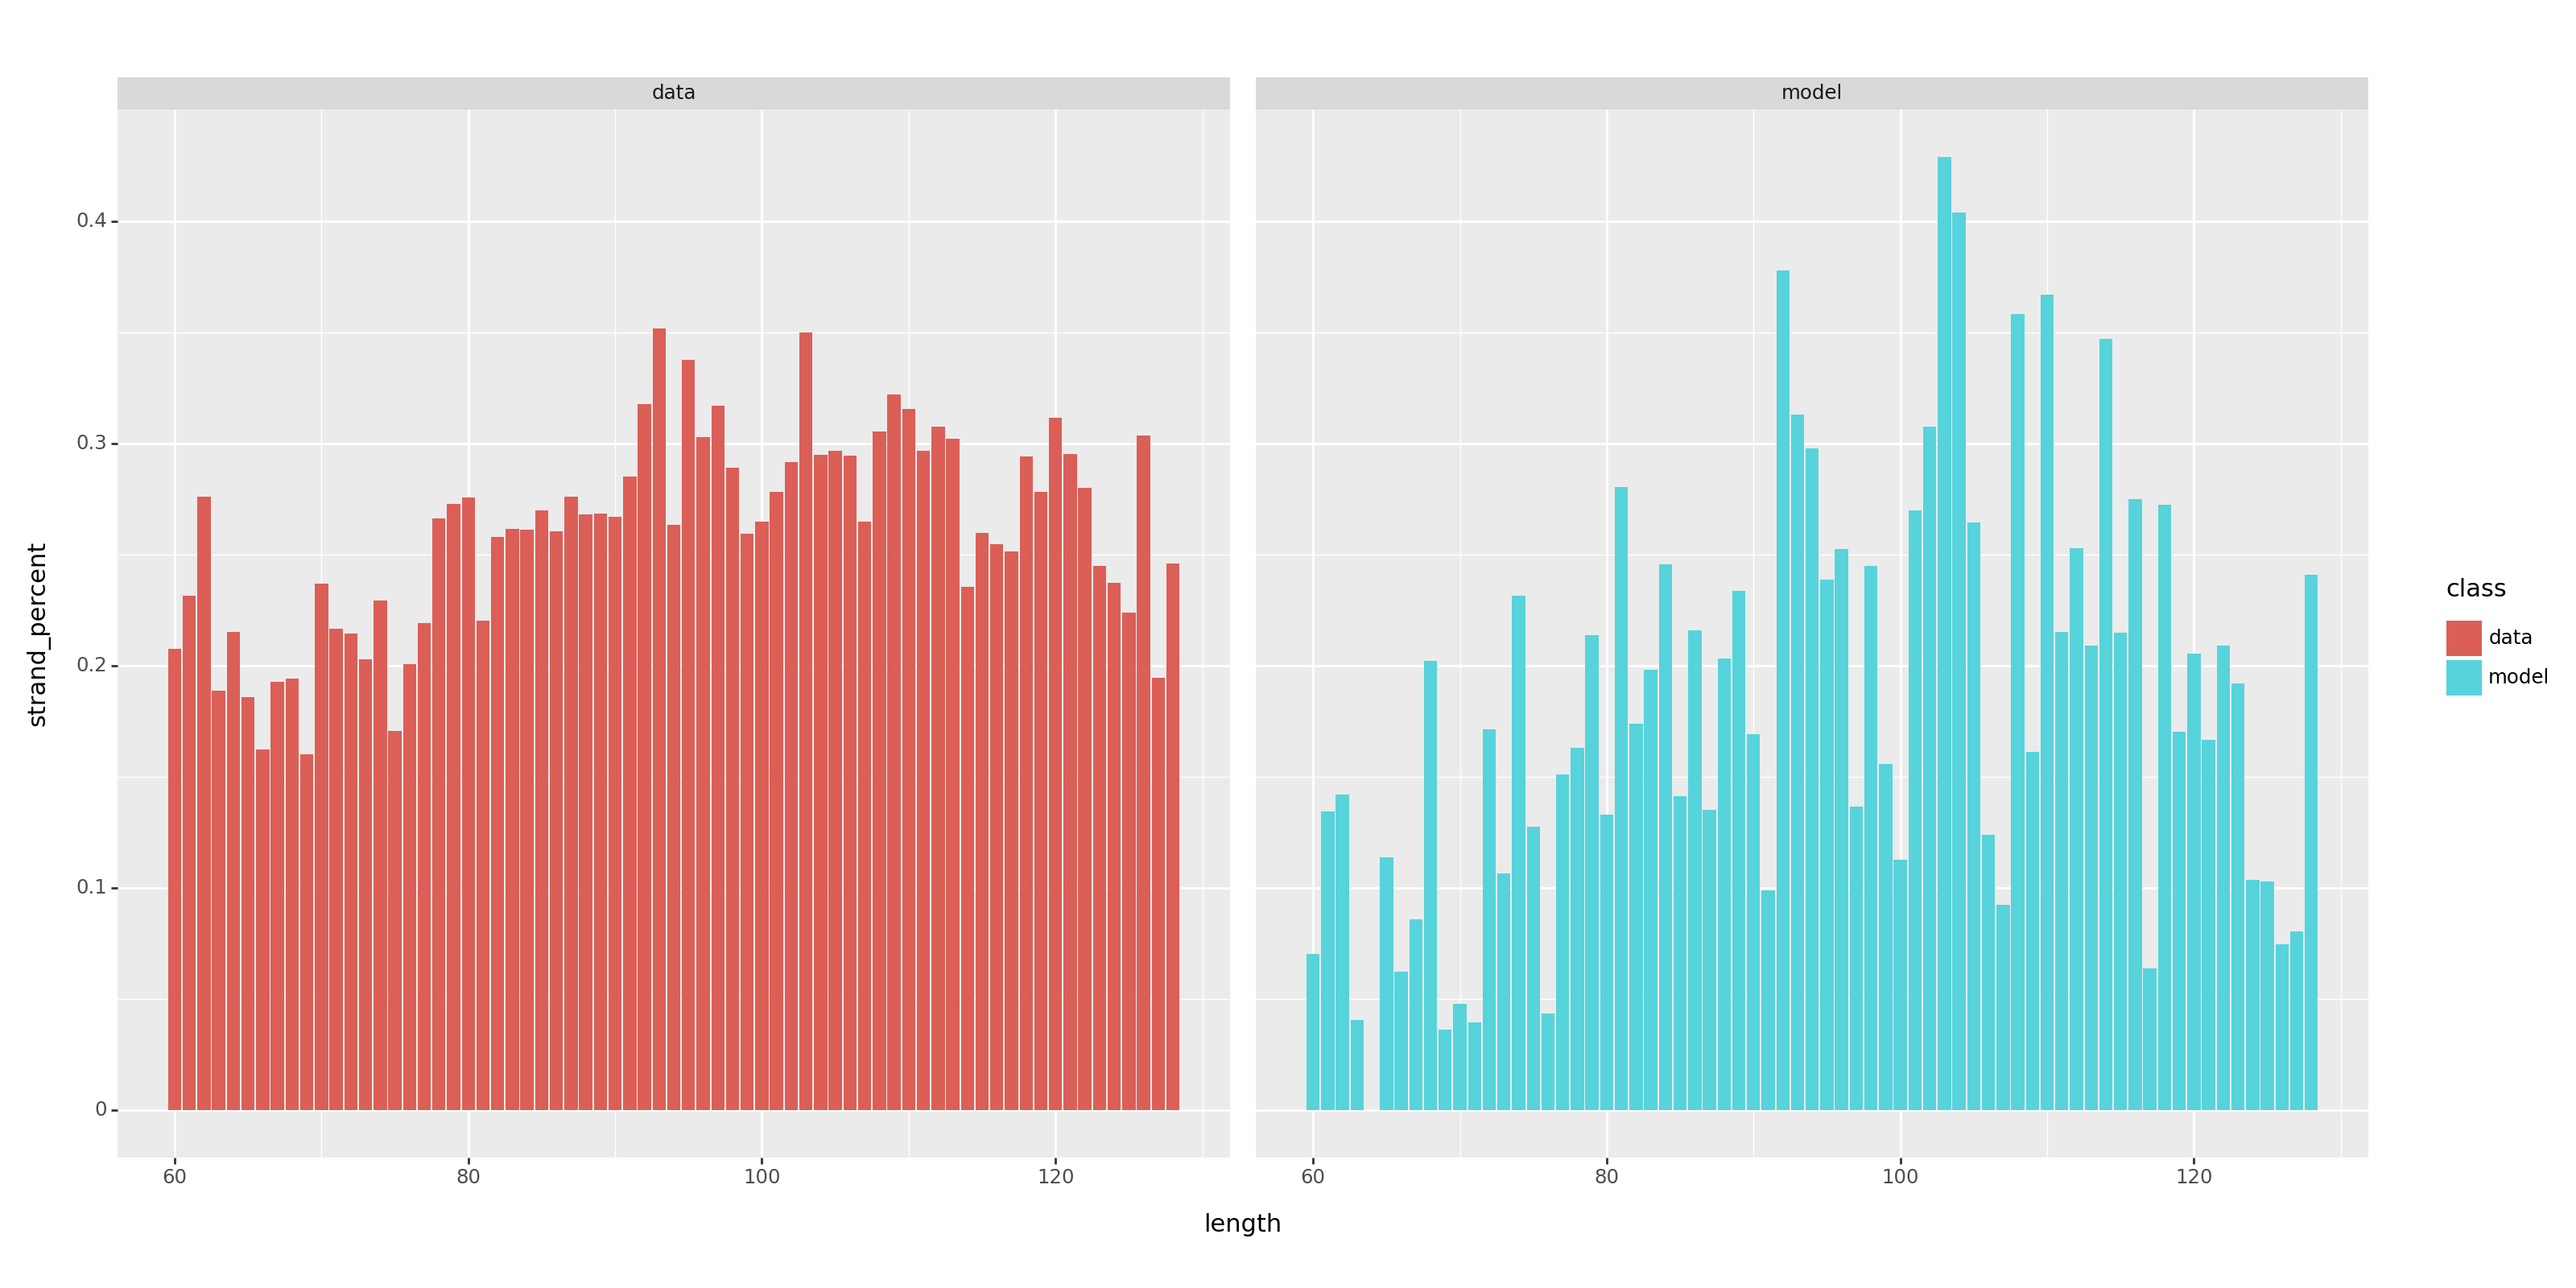

<Figure Size: (1600 x 800)>

In [134]:
(
    gg.ggplot(all_strand_per_length)
    + gg.geom_col(gg.aes(x='length', y='strand_percent', fill='class'))
    + gg.facet_wrap('class')
    # + gg.geom_col(gg.aes(x='length', y='strand_percent', fill='class'), position=gg.positions.position_dodge)
    + gg.theme(figure_size=(16, 8))
)

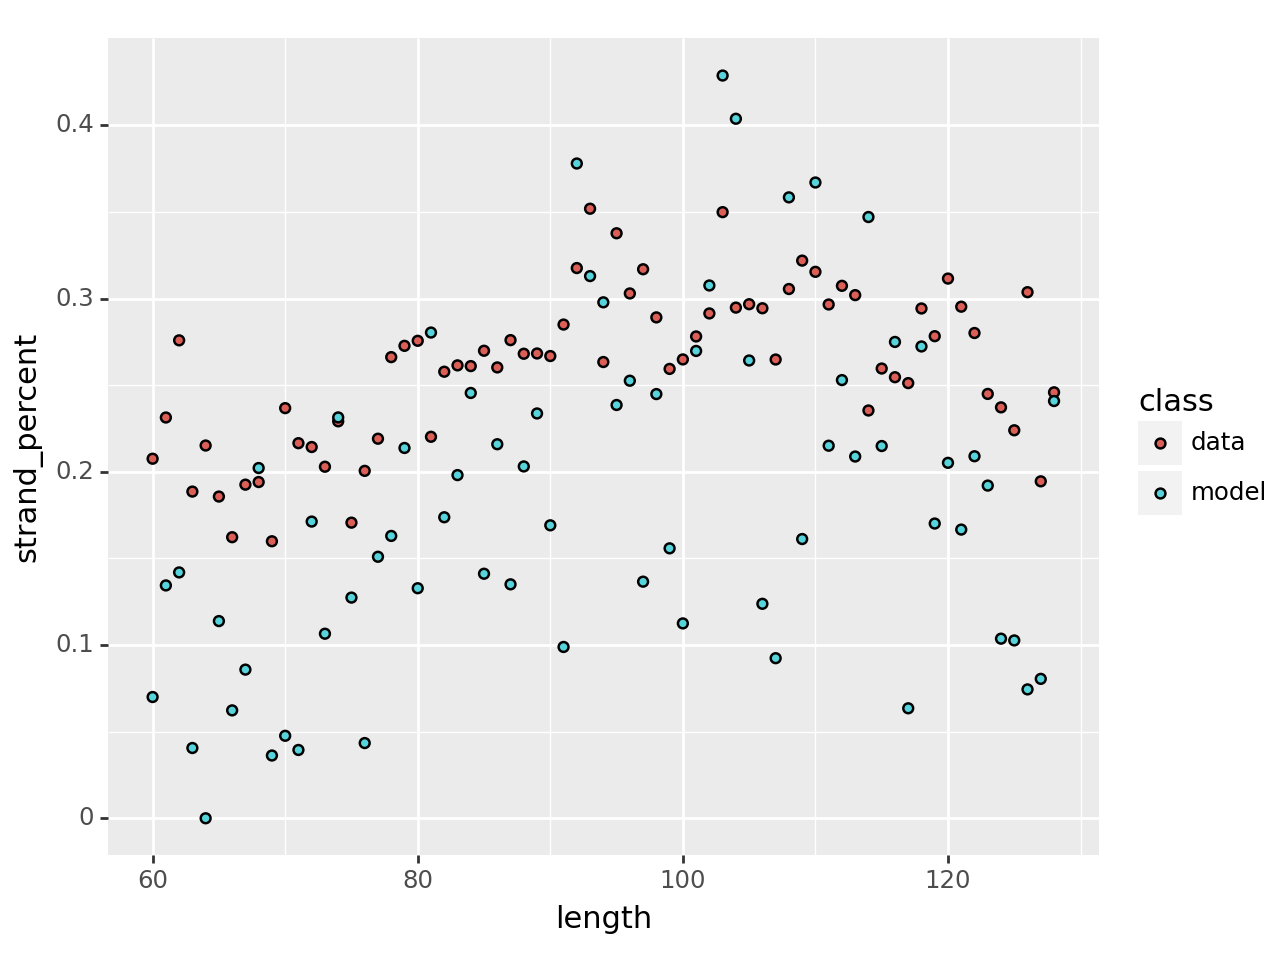

<Figure Size: (640 x 480)>

In [117]:
(
    gg.ggplot(all_strand_per_length)
    + gg.geom_col(gg.aes(x='length', y='helix_percent', fill='class'))
    + gg.facet_wrap('class')
    # + gg.geom_col(gg.aes(x='length', y='strand_percent', fill='class'), position=gg.positions.position_dodge)
    + gg.theme(figure_size=(16, 8))
)

In [118]:
# FrameFlow results analysis
def read_frameflow_samples(dir_path):
    all_csvs = glob.glob(os.path.join(results_dir, '*/top_samples.csv'))
    all_results_csv = []
    for csv in all_csvs:
        csv_df = pd.read_csv(csv)
        all_results_csv.append(csv_df)
    results_df = pd.concat(all_results_csv)
    designable_df = results_df[results_df.rmsd < 2.0]
    designable_percent = (results_df.rmsd < 2.0).mean()
    print(f'Designable percent: {designable_percent:.2f}. Designable number: {designable_df.shape[0]}')
    return results_df, designable_df

In [ ]:
results_dir = '/data/rsg/chemistry/jyim/projects/flow-matching/inference_outputs/refactor_with_align/2023-10-15_18-12-18/last/run_2023-10-18_00-30-21/'

In [122]:
# 100 timestep
# results_dir = os.path.join(results_base_dir, 'ts_100', 'frame_mpnn', 'reverse_time', 'ode')
write_base_dir = '/data/rsg/chemistry/jyim/third_party/frameflow_samples_2/ts_100'
results_df, designable_df = read_frameflow_samples(results_dir)
write_designable_samples(designable_df, write_base_dir)
print(
    '/data/rsg/chemistry/jyim/third_party/maxcluster64bit -l \\ \n' +
    f'{write_base_dir}/filename.txt \\ \n' + 
    f'{write_base_dir}/all_by_all_lite \\ \n' + 
    f'{write_base_dir}/maxcluster_results.txt'
)

Designable percent: 0.79. Designable number: 548
Done
/data/rsg/chemistry/jyim/third_party/maxcluster64bit -l \ 
/data/rsg/chemistry/jyim/third_party/frameflow_samples_2/ts_100/filename.txt \ 
/data/rsg/chemistry/jyim/third_party/frameflow_samples_2/ts_100/all_by_all_lite \ 
/data/rsg/chemistry/jyim/third_party/frameflow_samples_2/ts_100/maxcluster_results.txt


In [ ]:
./maxcluster64bit -l \
/data/rsg/chemistry/jyim/third_party/frameflow_samples_2/ts_100/filename.txt \
-C 2 -in -Rl /data/rsg/chemistry/jyim/third_party/frameflow_samples_2/ts_100/all_by_all_lite \
-TM -Tm 0.5 > /data/rsg/chemistry/jyim/third_party/frameflow_samples_2/ts_100/maxcluster_results.txt

In [123]:
foldseek easy-search /data/rsg/chemistry/jyim/third_party/frameflow_samples_2/ts_100 \
/Mounts/rbg-storage1/users/jyim/programs/foldseek/pdb aln_noise_01_seqs_100_esmf.m8 tmpFolder \
--alignment-type 1 --format-output 'query,target,alntmscore,lddt' --tmscore-threshold 0.0 --exhaustive-search --max-seqs 10000000000

0.3083941605839416

In [119]:
def calc_novelty(novelty_path):
    foldseek_df = {
        'sample': [],
        'alntm': [],
    }
    with open(novelty_path) as file:
        for item in file:
            file, _, _, tm_score = item.split('\t')
            tm_score = float(tm_score)
            foldseek_df['sample'].append(file)
            foldseek_df['alntm'].append(tm_score)
    foldseek_df = pd.DataFrame(foldseek_df)
    novelty_summary = foldseek_df.groupby('sample').agg({'alntm': 'max'}).reset_index()
    return novelty_summary


In [120]:
# FrameDiff results analysis
def read_samples(results_dir):
    all_csvs = []
    print(f'Reading samples from {results_dir}')
    for sample_length in os.listdir(results_dir):
        if '.' in sample_length:
            continue
        length_dir = os.path.join(results_dir, sample_length)
        length = int(sample_length.split('_')[1])
        for i,sample_name in enumerate(os.listdir(length_dir)):
            if '.' in sample_name:
                continue
            csv_path = os.path.join(length_dir, sample_name, 'self_consistency', 'sc_results.csv')
            if os.path.exists(csv_path):
                design_csv = pd.read_csv(csv_path, index_col=0)
                design_csv['length'] = length
                design_csv['sample_id'] = i
                all_csvs.append(design_csv)
    results_df = pd.concat(all_csvs)
    return results_df


def sc_filter(raw_df, metric):
    # Pick best self-consistency sample
    if metric == 'tm_score':
        df = raw_df.sort_values('tm_score', ascending=False)
        df['designable'] = df.tm_score.map(lambda x: x > 0.5)
    elif metric == 'rmsd':
        df = raw_df.sort_values('rmsd', ascending=True)
        df['designable'] = df.rmsd.map(lambda x: x < 2.0)
    else:
        raise ValueError(f'Unknown metric {metric}')
    df = df.groupby(['length', 'sample_id']).first().reset_index()
    percent_designable = df['designable'].mean()
    print(f'Percent designable: {percent_designable}')
    return df

In [121]:
# FrameFlow results analysis
def read_frameflow_samples(dir_path):
    all_csvs = glob.glob(os.path.join(results_dir, '*/top_samples.csv'))
    all_results_csv = []
    for csv in all_csvs:
        csv_df = pd.read_csv(csv)
        all_results_csv.append(csv_df)
    results_df = pd.concat(all_results_csv)
    designable_df = results_df[results_df.rmsd < 2.0]
    designable_percent = (results_df.rmsd < 2.0).mean()
    print(f'Designable percent: {designable_percent:.2f}. Designable number: {designable_df.shape[0]}')
    return results_df, designable_df

def write_designable_samples(designable_df, write_dir):
    os.makedirs(write_dir, exist_ok=True)
    pdb_list_path = os.path.join(write_dir, 'filename.txt')
    with open(pdb_list_path, 'w') as f:
        for (_, row) in designable_df.iterrows():
            pdb_path = row.esmf_pdb_path.replace('./', '../')
            length = row.length
            sample_id = row.sample_id
            write_path = os.path.join(write_dir, f'len_{length}_id_{sample_id}.pdb')
            f.write(write_path + '\n')
            shutil.copy(pdb_path, write_path)
    print('Done')

# FrameFlow analysis

In [11]:
results_base_dir = '/data/rsg/chemistry/jyim/projects/flow-matching/inference_outputs/baseline_2023-10-06_01-14-03_last'

## 500 timesteps

In [19]:
# 500 timestep
results_dir = os.path.join(results_base_dir, 'ts_500', 'frame_mpnn', 'reverse_time', 'ode')
write_base_dir = '/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_500'
results_df, designable_df = read_frameflow_samples(results_dir)
write_designable_samples(designable_df, write_base_dir)
print(
    '/data/rsg/chemistry/jyim/third_party/maxcluster64bit -l \\ \n' +
    f'{write_base_dir}/filename.txt \\ \n' + 
    f'{write_base_dir}/all_by_all_lite \\ \n' + 
    f'{write_base_dir}/maxcluster_results.txt'
)

Designable percent: 0.81. Designable number: 559
Done
/data/rsg/chemistry/jyim/third_party/maxcluster64bit -l \ 
/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_500/filename.txt \ 
/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_500/all_by_all_lite \ 
/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_500/maxcluster_results.txt


./maxcluster64bit -l \
/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_500/filename.txt \
-C 2 -in -Rl /data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_500/all_by_all_lite \
-TM -Tm 0.5 > /data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_500/maxcluster_results.txt

foldseek easy-search /data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_500 \
/Mounts/rbg-storage1/users/jyim/programs/foldseek/pdb aln_noise_01_seqs_500_esmf.m8 tmpFolder \
--alignment-type 1 --format-output 'query,target,alntmscore,lddt' --tmscore-threshold 0.0 --exhaustive-search --max-seqs 10000000000

In [53]:
foldseek_results_path = '/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_500/aln_noise_01_seqs_500_esmf.m8'
novelty_df = calc_novelty(foldseek_results_path)
novelty_df.alntm.mean()

0.6936939068100358

In [21]:
123 / 559

0.22003577817531306

## 100 timesteps

In [13]:
# 100 timestep
results_dir = os.path.join(results_base_dir, 'ts_100', 'frame_mpnn', 'reverse_time', 'ode')
write_base_dir = '/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_100'
results_df, designable_df = read_frameflow_samples(results_dir)
write_designable_samples(designable_df, write_base_dir)
print(
    '/data/rsg/chemistry/jyim/third_party/maxcluster64bit -l \\ \n' +
    f'{write_base_dir}/filename.txt \\ \n' + 
    f'{write_base_dir}/all_by_all_lite \\ \n' + 
    f'{write_base_dir}/maxcluster_results.txt'
)

Designable percent: 0.77. Designable number: 530
Done


./maxcluster64bit -l \
/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_100/filename.txt \
-C 2 -in -Rl /data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_100/all_by_all_lite \
-TM -Tm 0.5 > /data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_100/maxcluster_results.txt

foldseek easy-search /data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_100 \
/Mounts/rbg-storage1/users/jyim/programs/foldseek/pdb aln_noise_01_seqs_100_esmf.m8 tmpFolder \
--alignment-type 1 --format-output 'query,target,alntmscore,lddt' --tmscore-threshold 0.0 --exhaustive-search --max-seqs 10000000000

In [ ]:
147 / 530

In [43]:
foldseek_results_path = '/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_100/aln_noise_01_seqs_500_esmf.m8'
novelty_df = calc_novelty(foldseek_results_path)
novelty_df.alntm.mean()

FileNotFoundError: [Errno 2] No such file or directory: '/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_100/aln_noise_01_seqs_500_esmf.m8'

## 10 timesteps

In [20]:
# 10 timestep
results_dir = os.path.join(results_base_dir, 'ts_10', 'frame_mpnn', 'reverse_time', 'ode')
write_base_dir = '/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_10'
results_df, designable_df = read_frameflow_samples(results_dir)
write_designable_samples(designable_df, write_base_dir)
print(
    '/data/rsg/chemistry/jyim/third_party/maxcluster64bit -l \\ \n' +
    f'{write_base_dir}/filename.txt \\ \n' + 
    f'{write_base_dir}/all_by_all_lite \\ \n' + 
    f'{write_base_dir}/maxcluster_results.txt'
)

Designable percent: 0.33. Designable number: 228
Done
/data/rsg/chemistry/jyim/third_party/maxcluster64bit -l \ 
/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_10/filename.txt \ 
/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_10/all_by_all_lite \ 
/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_10/maxcluster_results.txt


./maxcluster64bit -l \
/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_10/filename.txt \
-C 2 -in -Rl /data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_10/all_by_all_lite \
-TM -Tm 0.5 > /data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_10/maxcluster_results.txt

foldseek easy-search /data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_10 \
/Mounts/rbg-storage1/users/jyim/programs/foldseek/pdb aln_noise_01_seqs_500_esmf.m8 tmpFolder \
--alignment-type 1 --format-output 'query,target,alntmscore,lddt' --tmscore-threshold 0.0 --exhaustive-search --max-seqs 10000000000

In [28]:
124 / 228

0.543859649122807

In [41]:
foldseek_results_path = '/data/rsg/chemistry/jyim/third_party/frameflow_samples/ts_10/aln_noise_01_seqs_500_esmf.m8'
novelty_df = calc_novelty(foldseek_results_path)
novelty_df.alntm.mean()

0.6302884444444445

# FrameDiff analysis

In [6]:
base_dir = '/data/rsg/chemistry/jyim/projects/flow-matching/se3_diffusion/inference_outputs'

## Scaled ODE 100 timesteps

In [22]:
# 100 timesteps with scaling
results_dir = os.path.join(base_dir, 'scaled_sde')
samples_df = read_samples(results_dir)
# samples_df = samples_df[samples_df.sample_id < 8] # Ensure we only consider 8 sequences per backbone.

scrmsd_results = sc_filter(samples_df, 'rmsd')
designable_scrmsd = scrmsd_results[scrmsd_results.designable]

# Write samples to a directory for diversity calculation.
write_dir = '/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100_scaled_ode'
os.makedirs(write_dir, exist_ok=True)
pdb_list_path = os.path.join(write_dir, 'filename.txt')
with open(pdb_list_path, 'w') as f:
    for (_, row) in designable_scrmsd.iterrows():
        pdb_path = row.sample_path.replace('./inference_outputs/', '/data/rsg/chemistry/jyim/projects/flow-matching/se3_diffusion/inference_outputs/')
        length = row.length
        sample_id = row.sample_id
        write_path = os.path.join(write_dir, f'len_{length}_id_{sample_id}.pdb')
        f.write(write_path + '\n')
        shutil.copy(pdb_path, write_path)


Reading samples from /data/rsg/chemistry/jyim/projects/flow-matching/se3_diffusion/inference_outputs/scaled_sde
Percent designable: 0.9159420289855073


./maxcluster64bit -l \
/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100_scaled_ode/filename.txt \
-C 2 -in -Rl /data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100_scaled_ode/all_by_all_lite \
-TM -Tm 0.5 > /data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100_scaled_ode//maxcluster_results.txt

In [23]:
scrmsd_results.designable.sum()

632

In [24]:
131 / 632

0.20727848101265822

## Scaled SDE 100 timesteps

In [14]:
# 100 timesteps with scaling
results_dir = os.path.join(base_dir, 'scaled_sde_true')
samples_df = read_samples(results_dir)
# samples_df = samples_df[samples_df.sample_id < 8] # Ensure we only consider 8 sequences per backbone.

scrmsd_results = sc_filter(samples_df, 'rmsd')
designable_scrmsd = scrmsd_results[scrmsd_results.designable]

# Write samples to a directory for diversity calculation.
write_dir = '/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100_scaled_sde'
os.makedirs(write_dir, exist_ok=True)
pdb_list_path = os.path.join(write_dir, 'filename.txt')
with open(pdb_list_path, 'w') as f:
    for (_, row) in designable_scrmsd.iterrows():
        pdb_path = row.sample_path.replace('./inference_outputs/', '/data/rsg/chemistry/jyim/projects/flow-matching/se3_diffusion/inference_outputs/')
        length = row.length
        sample_id = row.sample_id
        write_path = os.path.join(write_dir, f'len_{length}_id_{sample_id}.pdb')
        f.write(write_path + '\n')
        shutil.copy(pdb_path, write_path)


Reading samples from /data/rsg/chemistry/jyim/projects/flow-matching/se3_diffusion/inference_outputs/scaled_sde_true
Percent designable: 0.004347826086956522


## 500 timesteps

In [89]:
# 500 timesteps
results_dir = os.path.join(base_dir, 'scope_noise_scale_500')
samples_df = read_samples(results_dir)
samples_df = samples_df[samples_df.sample_id < 8] # Ensure we only consider 8 sequences per backbone.

scrmsd_results = sc_filter(samples_df, 'rmsd')
designable_scrmsd = scrmsd_results[scrmsd_results.designable]

# Write samples to a directory for diversity calculation.
write_dir = '/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_500'
os.makedirs(write_dir, exist_ok=True)
pdb_list_path = os.path.join(write_dir, 'filename.txt')
with open(pdb_list_path, 'w') as f:
    for (_, row) in designable_scrmsd.iterrows():
        pdb_path = row.sample_path.replace('./inference_outputs/scope_noise_scale_10', '/Mounts/rbg-storage1/users/jyim/se3_diffusion_scope_results/scope_noise_scale_10')
        length = row.length
        sample_id = row.sample_id
        write_path = os.path.join(write_dir, f'len_{length}_id_{sample_id}.pdb')
        f.write(write_path + '\n')
        shutil.copy(pdb_path, write_path)


Reading samples from /Mounts/rbg-storage1/users/jyim/se3_diffusion_scope_results/scope_noise_scale_10
Percent designable: 0.4221014492753623


./maxcluster64bit -l \
/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_500/filename.txt \
-C 2 -in -Rl /data/rsg/chemistry/jyim/third_party/framediff_samples/ts_500//all_by_all_lite \
-TM -Tm 0.5 > /data/rsg/chemistry/jyim/third_party/framediff_samples/ts_500//maxcluster_results.txt

In [93]:
84 / scrmsd_results.shape[0]

0.15217391304347827

foldseek easy-search /data/rsg/chemistry/jyim/third_party/framediff_samples/ts_500 \
/Mounts/rbg-storage1/users/jyim/programs/foldseek/pdb aln_noise_01_seqs_100_esmf.m8 tmpFolder \
--alignment-type 1 --format-output 'query,target,alntmscore,lddt' --tmscore-threshold 0.0 --exhaustive-search --max-seqs 10000000000

In [7]:
foldseek_results_path = '/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_500/aln_noise_01_seqs_100_esmf.m8'
novelty_df = calc_novelty(foldseek_results_path)
novelty_df.alntm.mean()

0.6625827893175075

## 100 timesteps

In [21]:
# 100 timesteps
results_dir = os.path.join(base_dir, 'redo_scope_ts_100_ode')
samples_df = read_samples(results_dir)
# samples_df = samples_df[samples_df.sample_id] # Ensure we only consider 8 sequences per backbone.

scrmsd_results = sc_filter(samples_df, 'rmsd')
designable_scrmsd = scrmsd_results[scrmsd_results.designable]
print(f'Num designable: {designable_scrmsd.shape[0]}')

# Write samples to a directory for diversity calculation.
write_dir = '/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100'
os.makedirs(write_dir, exist_ok=True)
pdb_list_path = os.path.join(write_dir, 'filename.txt')
with open(pdb_list_path, 'w') as f:
    for (_, row) in designable_scrmsd.iterrows():
        pdb_path = row.sample_path.replace('./inference_outputs', base_dir)
        length = row.length
        sample_id = row.sample_id
        write_path = os.path.join(write_dir, f'len_{length}_id_{sample_id}.pdb')
        f.write(write_path + '\n')
        shutil.copy(pdb_path, write_path)


Reading samples from /data/rsg/chemistry/jyim/projects/flow-matching/se3_diffusion/inference_outputs/redo_scope_ts_100_ode
Percent designable: 0.2561863173216885
Num designable: 176


./maxcluster64bit -l \
/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100/filename.txt \
-C 2 -in -Rl /data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100/all_by_all_lite \
-TM -Tm 0.5 > /data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100/maxcluster_results.txt

foldseek easy-search /data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100 \
/Mounts/rbg-storage1/users/jyim/programs/foldseek/pdb aln_noise_01_seqs_500_esmf.m8 tmpFolder \
--alignment-type 1 --format-output 'query,target,alntmscore,lddt' --tmscore-threshold 0.0 --exhaustive-search --max-seqs 10000000000

In [23]:
76 / 176

0.4318181818181818

In [26]:
foldseek_results_path = '/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100/aln_noise_01_seqs_500_esmf.m8'
novelty_df = calc_novelty(foldseek_results_path)
novelty_df.alntm.mean()

0.6562585227272727

## 10 timesteps

In [22]:
# 10 timesteps
results_dir = os.path.join(base_dir, 'scope_ts_10_ode')
samples_df = read_samples(results_dir)

scrmsd_results = sc_filter(samples_df, 'rmsd')
designable_scrmsd = scrmsd_results[scrmsd_results.designable]
print(f'Num designable: {designable_scrmsd.shape[0]}')

# Write samples to a directory for diversity calculation.
write_dir = '/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_10'
os.makedirs(write_dir, exist_ok=True)
pdb_list_path = os.path.join(write_dir, 'filename.txt')
with open(pdb_list_path, 'w') as f:
    for (_, row) in designable_scrmsd.iterrows():
        pdb_path = row.sample_path.replace('./inference_outputs', base_dir)
        length = row.length
        sample_id = row.sample_id
        write_path = os.path.join(write_dir, f'len_{length}_id_{sample_id}.pdb')
        f.write(write_path + '\n')
        shutil.copy(pdb_path, write_path)


Reading samples from /data/rsg/chemistry/jyim/projects/flow-matching/se3_diffusion/inference_outputs/scope_ts_10_ode
Percent designable: 0.1608695652173913
Num designable: 111


In [ ]:
./maxcluster64bit -l \
/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_10/filename.txt \
-C 2 -in -Rl /data/rsg/chemistry/jyim/third_party/framediff_samples/ts_10/all_by_all_lite \
-TM -Tm 0.5 > /data/rsg/chemistry/jyim/third_party/framediff_samples/ts_10/maxcluster_results.txt

foldseek easy-search /data/rsg/chemistry/jyim/third_party/framediff_samples/ts_10 \
/Mounts/rbg-storage1/users/jyim/programs/foldseek/pdb aln_noise_01_seqs_500_esmf.m8 tmpFolder \
--alignment-type 1 --format-output 'query,target,alntmscore,lddt' --tmscore-threshold 0.0 --exhaustive-search --max-seqs 10000000000

In [24]:
59 / 111

0.5315315315315315

In [25]:
foldseek_results_path = '/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_10/aln_noise_01_seqs_500_esmf.m8'
novelty_df = calc_novelty(foldseek_results_path)
novelty_df.alntm.mean()

0.6639600000000001

In [91]:
# 100 timesteps
results_dir = '/Mounts/rbg-storage1/users/jyim/se3_diffusion_scope_results/scope_noise_scale_10_ts_100'
samples_df = read_samples(results_dir)
samples_df = samples_df[samples_df.sample_id < 8] # Ensure we only consider 8 sequences per backbone.

scrmsd_results = sc_filter(samples_df, 'rmsd')
designable_scrmsd = scrmsd_results[scrmsd_results.designable]

# Write samples to a directory for diversity calculation.
write_dir = '/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100'
os.makedirs(write_dir, exist_ok=True)
pdb_list_path = os.path.join(write_dir, 'filename.txt')
with open(pdb_list_path, 'w') as f:
    for (_, row) in designable_scrmsd.iterrows():
        pdb_path = row.sample_path.replace('./inference_outputs/scope_noise_scale_10_ts_100', '/Mounts/rbg-storage1/users/jyim/se3_diffusion_scope_results/scope_noise_scale_10_ts_100')
        length = row.length
        sample_id = row.sample_id
        write_path = os.path.join(write_dir, f'len_{length}_id_{sample_id}.pdb')
        f.write(write_path + '\n')
        shutil.copy(pdb_path, write_path)


Reading samples from /Mounts/rbg-storage1/users/jyim/se3_diffusion_scope_results/scope_noise_scale_10_ts_100
Percent designable: 0.3894927536231884


./maxcluster64bit -l \
/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100/filename.txt \
-C 2 -in -Rl /data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100//all_by_all_lite \
-TM -Tm 0.5 > /data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100//maxcluster_results.txt

In [94]:
68 / scrmsd_results.shape[0]

0.12318840579710146

foldseek easy-search /data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100 \
/Mounts/rbg-storage1/users/jyim/programs/foldseek/pdb aln_noise_01_seqs_100_esmf.m8 tmpFolder \
--alignment-type 1 --format-output 'query,target,alntmscore,lddt' --tmscore-threshold 0.0 --exhaustive-search --max-seqs 10000000000

In [8]:
foldseek_results_path = '/data/rsg/chemistry/jyim/third_party/framediff_samples/ts_100/aln_noise_01_seqs_100_esmf.m8'
novelty_df = calc_novelty(foldseek_results_path)
novelty_df.alntm.mean()

0.6652191588785048

# GENIE results

In [45]:
def extract_ca(path):
    pdb_feats = du.parse_pdb_feats('a', path)
    return pdb_feats['bb_positions']

In [46]:
genie_samples_dir = '/Mounts/rbg-storage1/users/jyim/genie_results/eval_results/eval_results/ts_1000'
designs_dir = os.path.join(genie_samples_dir, 'pdbs/*')
structures_dir = os.path.join(genie_samples_dir, 'structures')

In [51]:
designs_to_score = {
    'sample_id': [],
    'length': [],
    'min_rmsd': [],
    'pdb_path': [],
    'max_tm': [],
}
all_samples = glob.glob(designs_dir)

for i,design_path in enumerate(all_samples):
    design_fname = os.path.basename(design_path).replace('.pdb', '')
    length, sample_id = [int(x) for x in design_fname.split('_')]
    if length < 60:
        continue
    # path_basename = '/'.join(design_path.split('/')[-2:])
    # design_path = os.path.join(genie_samples_dir, path_basename)
    design_pdb = extract_ca(design_path)
    res_mask = np.ones_like(design_pdb)[:, 0]
    max_tm = 0
    min_rmsd = 1000
    if i % 50 == 0:
        print(f'On {i}/{len(all_samples)}')
    for i in range(8):
        resample_path = os.path.join(structures_dir, f'{design_fname}-resample_{i}.pdb')
        resample_pdb = extract_ca(resample_path)
        _, rmsd = superimpose(
            torch.tensor(resample_pdb[None]),
            torch.tensor(design_pdb[None]),
            torch.tensor(res_mask[None])
        )
        num_res = resample_pdb.shape[0]
        seq = 'A'*num_res
        tm_results = tm_align(design_pdb, resample_pdb, seq, seq)
        tm_score = tm_results.tm_norm_chain1
        if rmsd < min_rmsd:
            min_rmsd = rmsd
        if tm_score > max_tm:
            max_tm = tm_score
    designs_to_score['sample_id'].append(sample_id)
    designs_to_score['length'].append(length)
    designs_to_score['min_rmsd'].append(min_rmsd)
    designs_to_score['max_tm'].append(max_tm)
    designs_to_score['pdb_path'].append(design_path)
    
results_df = pd.DataFrame(designs_to_score)
scrmsd_designability = (results_df.min_rmsd < 2.0).mean()
sctm_designability = (results_df.max_tm > 0.5).mean()
print(f'scRMSD designability: {scrmsd_designability}')
print(f'scTM designability: {sctm_designability}')

On 0/790
On 50/790
On 100/790
On 150/790
On 200/790
On 250/790
On 300/790
On 350/790
On 400/790
On 500/790
On 550/790
On 600/790
On 700/790
On 750/790
scRMSD designability: 0.22318840579710145
scTM designability: 0.14057971014492754


In [52]:
(results_df.max_tm > 0.5).mean()

0.8594202898550725

In [116]:
genie_samples_dir = '/Mounts/rbg-storage1/users/jyim/genie_results/eval_results/eval_results/ts_500'
designs_dir = os.path.join(genie_samples_dir, 'pdbs/*')
structures_dir = os.path.join(genie_samples_dir, 'structures')